In [2]:
import sys
import os

# add the main directory to the notebook
sys.path.append(os.path.abspath(os.path.join('/home/lazaror/quantum/pruebas/EQCNN_local_testing/EQNN_for_HEP')))

import numpy as np
from Equivariant_QCNN.data.data import data_load_and_process
from Equivariant_QCNN.training.Training import circuit_training
from Equivariant_QCNN.models.QCNN_circuit import QCNN
import matplotlib.pyplot as plt
from Equivariant_QCNN.benchmarking.Benchmarking import accuracy_test, round_predictions_f
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-09-23 04:47:55.199556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
"""
Here are possible combinations of benchmarking user could try.
Unitaries: ['U_TTN', 'U2_equiv', 'U4_equiv', 'U_5', 'U_6', 'U_9', 'U_13', 'U_14', 'U_15', 'U_SO4', 'U_SU4', 'U_SU4_no_pooling', 'U_SU4_1D', 'U_9_1D']
U_num_params: [2, 6, 6, 10, 10, 2, 6, 6, 4, 6, 15, 15, 15, 2]
feature_reduction: ['img_16x16','resize_flat_16x16', 'pca_8']
embedding_type: ["Equivariant-Amplitude", "Amplitude", "Angle", "Angle-compact"]
dataset: 'mnist', 'fashion_mnist', 'electron_photon' or "quark-gluon"
circuit: 'QCNN' 
cost_fn: 'mse' or 'cross_entropy'
Note: when using 'mse' as cost_fn binary="True" is recommended, when using 'cross_entropy' as cost_fn must be binary="False".
"""


# invariant testings

# U2_equiv is invariant under p4m using MSE
# U2_equiv is invariant under reflections over X using cross_entropy 


params = np.random.randn(40)
U_params = 6
U = "U2_equiv"
embedding_type = "Equivariant-Amplitude"
layers = 10
circuit = "QCNN"
cost_fn = "mse"
binary = True
dataset = "electron_photon"

X_train, X_test, Y_train, Y_test =  data_load_and_process(dataset = dataset, classes=[1,0], feature_reduction= "img16x16x1", binary=True)

print(X_train.shape)

(20000, 16, 16, 1)


2024-09-23 04:48:03.015009: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
train_samples = 2000
layers = 5

loss_history, train_acc_history, trained_params = circuit_training(X_train[:train_samples], Y_train[:train_samples], U, U_params, embedding_type, layers, circuit, cost_fn, opt_type = "Nesterov", steps=10, initial_learning_rate=0.5, batch_size=128, decay_factor=0.5, decay_steps=10)

iteration:  0  cost:  1.0137154490604867 train_accuracy: 0.51953125
iteration:  1  cost:  1.0001167700844957 train_accuracy: 0.521484375
iteration:  2  cost:  1.0033729452583464 train_accuracy: 0.51953125
iteration:  3  cost:  0.9612686036303337 train_accuracy: 0.51953125
iteration:  4  cost:  0.9998408498719268 train_accuracy: 0.51953125
iteration:  5  cost:  0.9998880201772927 train_accuracy: 0.51953125
iteration:  6  cost:  0.9967470692891174 train_accuracy: 0.47265625
iteration:  7  cost:  0.993685665118925 train_accuracy: 0.51953125
iteration:  8  cost:  0.9923750124262442 train_accuracy: 0.51953125
iteration:  9  cost:  0.9921611814611313 train_accuracy: 0.51953125
Learning rate reduced to: 0.25


-1
 Output with Probabilities for Original Image: 0.09020986195422316
 Output with Probabilities for Image Reflected over Y-axis: 0.09020986195422316
 Output with Probabilities for Image Reflected over X-axis: 0.09020986195422312
 Output with Probabilities for Image Rotated 90 Degrees: 0.09020986195422309


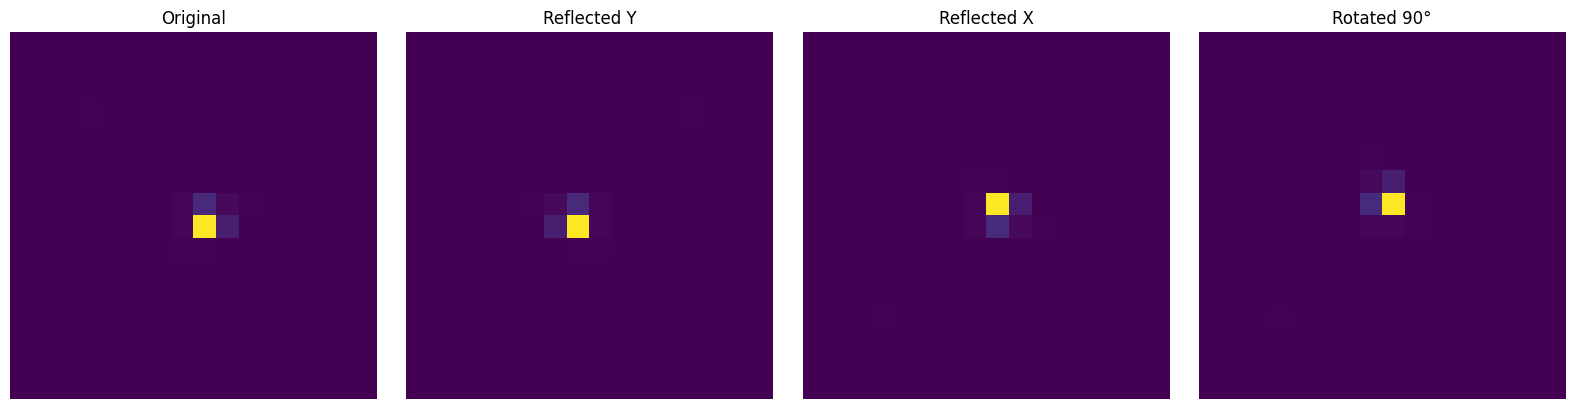

In [5]:
n_qubits = 8
layers = 3
#data and transformed data
matrix = np.array(X_train[1])
matrix_reflected_y = np.fliplr(matrix) # Image Reflected over Y-axis
matrix_reflected_x = np.flipud(matrix) # Image Reflected over X-axis
matrix_rotated_90 = np.rot90(matrix) # Image rotated 90 degrees

print(Y_train[1])
result1 = QCNN(matrix, trained_params, U, U_params, embedding_type, cost_fn, layers )
result2 = QCNN(matrix_reflected_y, trained_params, U, U_params, embedding_type, cost_fn, layers )
result3 = QCNN(matrix_reflected_x, trained_params, U, U_params, embedding_type, cost_fn, layers )
result4 = QCNN(matrix_rotated_90, trained_params, U, U_params, embedding_type, cost_fn, layers )

print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title('Original')
plt.imshow(matrix)
plt.axis('off')  

plt.subplot(1, 4, 2)
plt.title('Reflected Y')
plt.imshow(matrix_reflected_y)
plt.axis('off') 

plt.subplot(1, 4, 3)
plt.title('Reflected X')
plt.imshow(matrix_reflected_x)
plt.axis('off')  

plt.subplot(1, 4, 4)
plt.title('Rotated 90°')
plt.imshow(matrix_rotated_90)
plt.axis('off') 

plt.tight_layout()  

plt.show()

In [16]:
test_samples = 500

predictions = [QCNN(x, trained_params, U, U_params, embedding_type, cost_fn, layers) for x in X_test[:test_samples]]

accuracy = accuracy_test(predictions, Y_test[:test_samples], cost_fn, binary)
accuracy

0.518

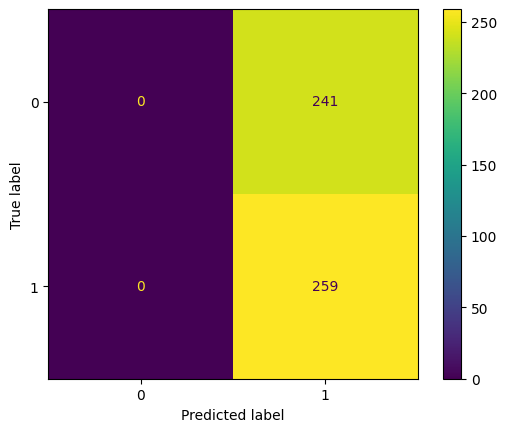

In [17]:
round_predictions = round_predictions_f(predictions, cost_fn)

cm = confusion_matrix(Y_test[:test_samples], round_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

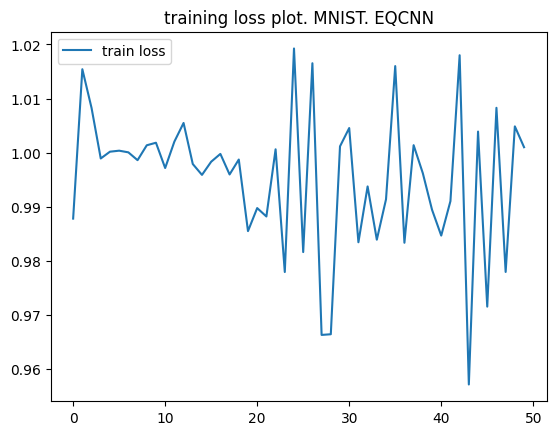

In [18]:
plt.plot(loss_history, label = "train loss")
plt.title("training loss plot. MNIST. EQCNN")
plt.yscale("linear")
plt.legend()
plt.show()

In [19]:
predictions

[tensor(0.10250037, requires_grad=True),
 tensor(0.10232722, requires_grad=True),
 tensor(0.10342326, requires_grad=True),
 tensor(0.10255909, requires_grad=True),
 tensor(0.1034193, requires_grad=True),
 tensor(0.10243565, requires_grad=True),
 tensor(0.10260573, requires_grad=True),
 tensor(0.10248289, requires_grad=True),
 tensor(0.10248897, requires_grad=True),
 tensor(0.10254958, requires_grad=True),
 tensor(0.10764164, requires_grad=True),
 tensor(0.10301277, requires_grad=True),
 tensor(0.10266333, requires_grad=True),
 tensor(0.10265785, requires_grad=True),
 tensor(0.10264265, requires_grad=True),
 tensor(0.10240912, requires_grad=True),
 tensor(0.10250144, requires_grad=True),
 tensor(0.10292497, requires_grad=True),
 tensor(0.10261504, requires_grad=True),
 tensor(0.10250124, requires_grad=True),
 tensor(0.10338838, requires_grad=True),
 tensor(0.10260705, requires_grad=True),
 tensor(0.10407689, requires_grad=True),
 tensor(0.10247713, requires_grad=True),
 tensor(0.1027630